In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

In [2]:
def getData(year,months=['01','02','03','04','05','06','07','08','09','10','11','12']):
    # procedure accepts year (as string) and optional list of months (strings) for which to retreive data
    # will return a df with the DIVVY data for that year and month(s)
    import pandas as pd

    if not isinstance(year,str):
        year = str(year)

    if not isinstance(months,list):
        months = [months]

    if int(year) >= 2020:
        workDir = '/home/alp/Google Drive/Python/DataSets/Data_Divvy/'
    else:
        workDir = '/home/alp/Google Drive/Python/DataSets/Data_Divvy/pre2020/'

    fileName = year + months[0] + '-divvy-tripdata.json'
    print(fileName)
    retData = pd.read_json(workDir+fileName,orient='index')

    if len(months) > 0:
        for month in months[1:]:
                fileName = year + month + '-divvy-tripdata.json'
                print(fileName)
                newData = pd.read_json(workDir+fileName,orient='index')
                retData = pd.concat([retData,newData])

    return retData

In [3]:
def getYear(year):
    data = getData(year)
    data.drop(columns=['ride_id', 'start_station_name', 'end_station_name'],inplace=True)
    data.rename(columns={'started_at':'start_time','ended_at':'end_time','member_casual':'usertype'},inplace=True)
    data['tripduration'] = data['end_time'] - data['start_time']
    data.drop(data[data['tripduration'] < '0:00:00'].index, inplace=True)
    return data


In [4]:
#data21 = getData('2021')
#data21.drop(columns=['ride_id', 'start_station_name', 'end_station_name'],inplace=True)
#data21.rename(columns={'started_at':'start_time','ended_at':'end_time','member_casual':'usertype'},inplace=True)
#data21['tripduration'] = data21['end_time'] - data21['start_time']
#data21.drop(data21[data21['tripduration'] < '0:00:00'].index, inplace=True)


The kernal crashes randomly, because (I think) it's running close to out of memory. If I can define the DFs in a subroutine, they should be dumped from memory after use.
So rather than creating data20 and data21 dfs prior to concating them to create the working df (bigData), lets try to do this in a procedure, by creating "get year".

In [5]:
bigData = pd.concat([getYear('2020'),getYear('2021')],axis=0)


202001-divvy-tripdata.json
202002-divvy-tripdata.json
202003-divvy-tripdata.json
202004-divvy-tripdata.json
202005-divvy-tripdata.json
202006-divvy-tripdata.json
202007-divvy-tripdata.json
202008-divvy-tripdata.json
202009-divvy-tripdata.json
202010-divvy-tripdata.json
202011-divvy-tripdata.json
202012-divvy-tripdata.json
202101-divvy-tripdata.json
202102-divvy-tripdata.json
202103-divvy-tripdata.json
202104-divvy-tripdata.json
202105-divvy-tripdata.json
202106-divvy-tripdata.json
202107-divvy-tripdata.json
202108-divvy-tripdata.json
202109-divvy-tripdata.json
202110-divvy-tripdata.json
202111-divvy-tripdata.json
202112-divvy-tripdata.json


It looks like "classic_bike" and "docked_bike" refer to the same type of bike, although there isn't a clean break from one term to the other. For my purposes, I think adding them together is OK, since we want to think about how e-bikes are used differently from non-E-bikes.

Since "classic_bike" seems to be the more common term going forward, we will change "docked" to "classic."

In [6]:
bigData['month'] = pd.DatetimeIndex(bigData['start_time']).month
bigData['year'] = pd.DatetimeIndex(bigData['start_time']).year
bigData['rideable_type'].replace(to_replace = 'docked_bike', value = 'classic_bike',inplace = True)

In [7]:
bigData.columns

Index(['rideable_type', 'start_time', 'end_time', 'start_station_id',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'usertype', 'tripduration', 'month', 'year'],
      dtype='object')

In [8]:
bigData['rideable_type'].value_counts()

classic_bike     6538112
electric_bike    2527870
Name: rideable_type, dtype: int64

In [12]:
bikeType = bigData.pivot_table(index=['rideable_type','usertype'],columns = ['year','month'],values='start_time',aggfunc='count').T


Text(0, 0.5, 'Rides per month')

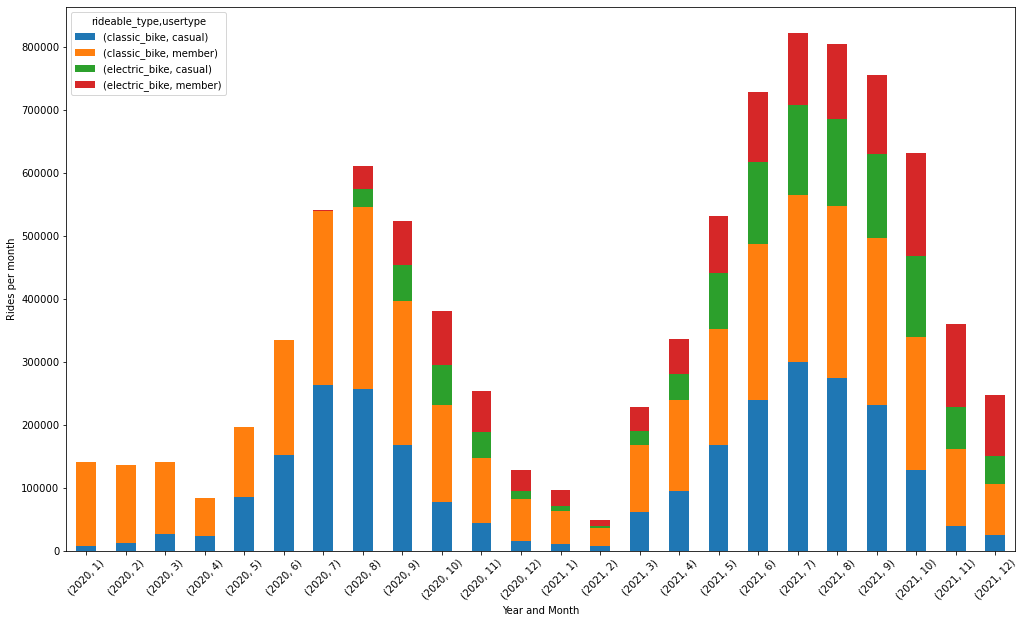

In [13]:
bikeType.plot(kind='bar',stacked = True, figsize=(17,10))
plt.xticks(rotation=45,horizontalalignment = 'center')
plt.xlabel('Year and Month')
plt.ylabel('Rides per month')

Well, that's not particularly easy to read.

Instead of total counts, lets plot the percent of rides by bike type

<AxesSubplot:xlabel='year,month'>

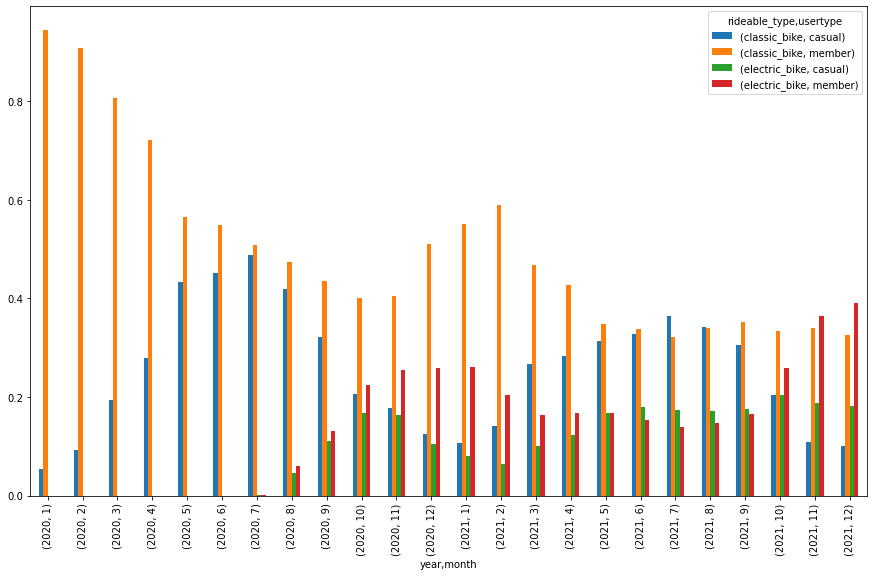

In [14]:
temp = pd.crosstab([bigData.rideable_type,bigData.usertype],[bigData.year,bigData.month],
    values=bigData.start_time,aggfunc = 'count', normalize = 'columns').T
temp.plot(kind = 'bar',figsize=(15,9))
    

Well, that's easier to read. But lets rotate it.

Text(0.5, 1.0, 'Change in type of bikes ridden by casual or member users per month')

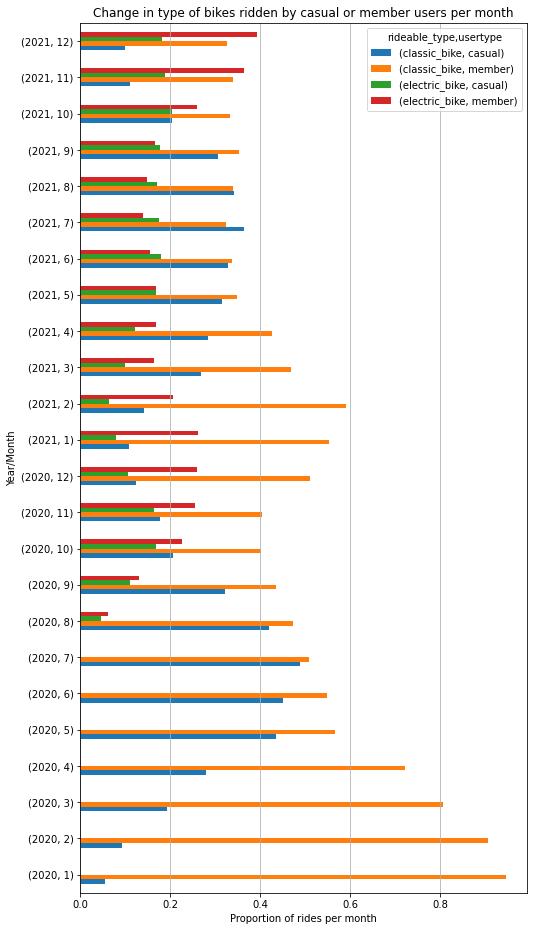

In [15]:
temp.plot(kind = 'barh',figsize=(8,16))
plt.ylabel('Year/Month')
#plt.xticks(rotation=45,horizontalalignment = 'right')
#plt.yticks(np.arange(0,1.05,.1))
plt.xlabel('Proportion of rides per month')
plt.grid(axis='x')
plt.title("Change in type of bikes ridden by casual or member users per month")


Text(0.5, 1.0, "Number of 'casual' Divvy rides per month")

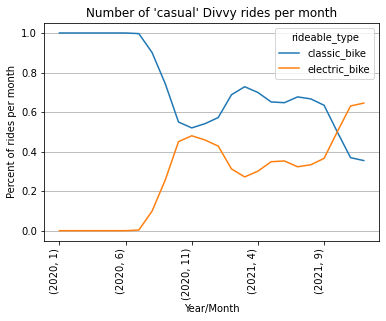

In [16]:
temp = bigData[bigData['usertype'] == 'casual']
tempGraph = pd.crosstab([temp.rideable_type],[temp.year,temp.month],
    values=temp.start_time,aggfunc = 'count', normalize = 'columns').T
tempGraph.plot()#kind='bar',stacked = True)
plt.xticks(rotation=90,horizontalalignment = 'right')
plt.xlabel('Year/Month')
plt.ylabel('Percent of rides per month')
#plt.yticks(np.arange(0,450000,100000))
plt.grid(axis='y')
plt.title("Number of 'casual' Divvy rides per month")
    

The line graph isn't particularly helpful. Let's try bar graph. . . 

Text(0.5, 1.0, "Change in type of bikes ridden by 'member' users per month")

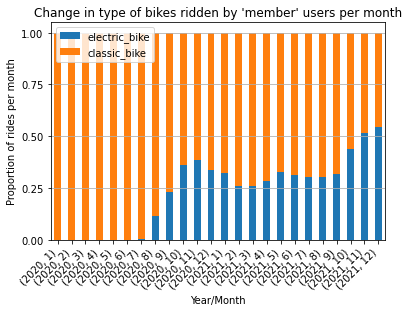

In [17]:
userT = 'member'
temp = bigData[bigData['usertype'] == userT]
tempGraph = pd.crosstab([temp.rideable_type],[temp.year,temp.month],
    values=temp.start_time,aggfunc = 'count', normalize = 'columns').T
# since the crosstab defaults to alpha order for "ridable_type", let's swap the two columns, so we can put the e-bike data on the bottom of the graph
tempGraph = tempGraph[['electric_bike','classic_bike']]

tempGraph.plot(kind='bar',stacked = True).legend(loc = 'upper left')
plt.xticks(rotation=45,horizontalalignment = 'right')
plt.xlabel('Year/Month')
plt.yticks(np.arange(0,1.1,.25))
plt.ylabel('Proportion of rides per month')
plt.grid(axis='y')
plt.title("Change in type of bikes ridden by '" + userT + "' users per month")
    

Text(0.5, 1.0, "Change in type of bikes ridden by 'casual' users per month")

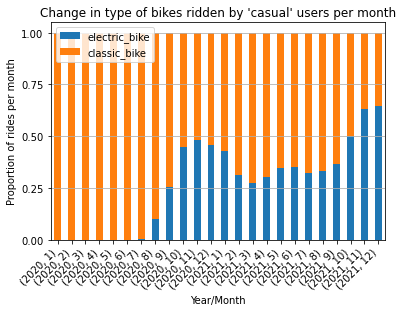

In [18]:
userT = 'casual'
temp = bigData[bigData['usertype'] == userT]
tempGraph = pd.crosstab([temp.rideable_type],[temp.year,temp.month],
    values=temp.start_time,aggfunc = 'count', normalize = 'columns').T
tempGraph = tempGraph[['electric_bike','classic_bike']]

tempGraph.plot(kind='bar',stacked = True).legend(loc = 'upper left')
plt.xticks(rotation=45,horizontalalignment = 'right')
plt.xlabel('Year/Month')
plt.yticks(np.arange(0,1.2,.25))
plt.ylabel('Proportion of rides per month')
plt.grid(axis='y')
plt.title("Change in type of bikes ridden by '" + userT + "' users per month")
    

Well, there are two graphs, but they are easier to read!

I've done maps to see where different user types get and return bikes. Let's see if there is a different pattern for e-bikes and trad bikes.

Happily, we can reuse the code for creating the maps; we just need to change the loop calling the map drawing procedue.

In [20]:
station_list = bigData.drop_duplicates(subset='start_station_id')
station_list.drop(columns=['start_time', 'end_time', 'usertype','tripduration','month','year'],inplace=True)

/tmp/ipykernel_144118/1852133900.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_list.drop(columns=['start_time', 'end_time', 'usertype','tripduration','month','year'],inplace=True)


In [21]:
station_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1504 entries, 99279 to 97633
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rideable_type     1504 non-null   object 
 1   start_station_id  1503 non-null   object 
 2   end_station_id    1407 non-null   object 
 3   start_lat         1504 non-null   float64
 4   start_lng         1504 non-null   float64
 5   end_lat           1504 non-null   float64
 6   end_lng           1504 non-null   float64
dtypes: float64(4), object(3)
memory usage: 94.0+ KB


In [37]:
def createMapdf(year,col,df):
    temp = df[df['year'] == year]
    busy_stations = temp[col].value_counts().head(20).to_frame().reset_index()
    busy_stations.rename(columns={col:'count','index':col},inplace=True)
    busy_stations[col] = busy_stations[col].astype(str)
    return busy_stations.merge(station_list,how='left',left_on=col,right_on=['start_station_id'])
    # because I created the station_list by removing dups of the start_station_id, when merging on it 
    # with 'end_station_id', it returns multiple rows per some stations. drop_duplicates makes sure to get 
    # rid of those

def mapBusyStations(year,df):
    import folium
    
    start_stations = createMapdf(year,'start_station_id',df)
    end_stations = createMapdf(year,'end_station_id',df)

    m1 = folium.Map(location = [start_stations['start_lat'].mean(),start_stations['start_lng'].mean()],
                tiles='cartodbpositron',zoom_start = 11)

    title = '20 most popular start (green) and end (red) stations in '+str(year)
    title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(title)
    m1.get_root().html.add_child(folium.Element(title_html)) 

    for index, row in end_stations.iterrows():   
        folium.CircleMarker(location=[row['end_lat'],row['end_lng']],
            radius = row['count']/5000,
            color = 'red',
            tooltip=str(row['count']),
            fill = True
                    ).add_to(m1)

    for index, row in start_stations.iterrows():
        folium.CircleMarker(location=[row['start_lat'],row['start_lng']],
            radius = row['count']/5000,
            color = 'green',
            tooltip=str(row['count']),
            fill = True
                    ).add_to(m1)

    return m1


    

In [24]:
#m1 = mapBusyStations(2020,bigData[bigData['rideable_type']=='classic_bike'])
#m1
#start_stations = createMapdf(2020,'start_station_id',bigData[bigData['rideable_type']=='classic_bike'])
#end_stations = createMapdf(2020,'end_station_id',bigData[bigData['usertype']=='classic_bike'])
#m1

df = bigData[bigData['rideable_type']=='classic_bike']
col = 'start_station_id'
temp = df[df['year'] == 2020]
busy_stations = temp[col].value_counts().head(20).to_frame().reset_index()
busy_stations.rename(columns={col:'count','index':col},inplace=True)
#busy_stations[col] = busy_stations[col].astype(str)
bs = busy_stations.merge(station_list,how='left',left_on=col,right_on=['start_station_id'])
#busy_stations.head()
busy_stations.head()

,index,start_station_id
0,35.0,32265
1,176.0,26573
2,177.0,26569
3,76.0,26078
4,268.0,23702


In [27]:
bs = busy_stations.merge(station_list,how='left',left_on=col,right_on=['start_station_id'])
bs.head()

,start_station_id,count,rideable_type,end_station_id,start_lat,start_lng,end_lat,end_lng
0,35.0,32265,NaN,NaN,NaN,NaN,NaN,NaN
1,176.0,26573,NaN,NaN,NaN,NaN,NaN,NaN
2,177.0,26569,NaN,NaN,NaN,NaN,NaN,NaN
3,76.0,26078,NaN,NaN,NaN,NaN,NaN,NaN
4,268.0,23702,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
station_list.head()

,rideable_type,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng
99279,classic_bike,115.0,246.0,41.9363,-87.6527,41.9561,-87.6688
143776,classic_bike,81.0,81.0,41.8842,-87.6296,41.8842,-87.6296
39811,classic_bike,240.0,256.0,41.9542,-87.6544,41.9528,-87.6500
94468,classic_bike,626.0,59.0,41.8675,-87.6322,41.8672,-87.6260
9415,classic_bike,326.0,318.0,41.9671,-87.6674,41.9542,-87.6644


In [ ]:
for i in range (2020,2022):
    for j in ['classic_bike','electric_bike']:
        fn = str(i)+j+'.html'
        mapBusyStations(i,bigData[bigData['usertype']==j]).save(fn)
        print(fn)